<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson_14_YOLO_Loss_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Урок 14: YOLO — Loss-функции, визуализация IoU, контроль глубины
Полный обзор одной из ключевых тем в object detection — как модели YOLO обучаются через функцию потерь, как визуализируются ошибки, и как на основе предсказаний можно оценить глубину объектов.

## 1️⃣ Теория: Компоненты Loss-функции в YOLO

YOLO использует **мультизадачную функцию потерь**, состоящую из трёх компонентов:

### 1.1 Localization Loss (координаты бокса):
Используется **MSE** между предсказанными и истинными координатами:
$$
\mathcal{L}_{coord} = \lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{obj} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 + (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2 \right]
$$
- $x, y$ — координаты центра;
- $w, h$ — ширина и высота;
- $\mathbb{1}_{ij}^{obj}$ — индикатор наличия объекта.

YOLO использует $\sqrt{w}$ и $\sqrt{h}$ вместо самих $w, h$, чтобы сбалансировать влияние больших и маленьких объектов:

Если бы мы использовали просто $(w_i - \hat{w}_i)^2$, большие боксы дали бы намного больше ошибку, чем маленькие — модель бы "игнорировала" маленькие объекты.

Корень сглаживает влияние: он делает ошибку более относительной по размеру.

### 🧠 Что означают индексы в YOLO Loss

#### 🔷 Индекс \( i \):
- Это **ячейка сетки (grid cell)**, на которую разбито изображение.
- YOLO делит изображение на сетку размером \( S \times S \) — например, 7×7.
- Всего будет \( S^2 \) ячеек.
- Каждая ячейка отвечает за **обнаружение объекта, чей центр попадает в неё**.

**Пример:**  
Если \( S = 7 \), то \( i \in \{0, 1, ..., 48\} \) — всего 49 ячеек.

#### 🔷 Индекс \( j \):
- Это номер одного из **\( B \)** предсказанных боксов в ячейке.
- В каждой ячейке YOLO предсказывает \( B \) bounding boxes (обычно \( B = 2 \)).
- Поэтому \( j \in \{0, 1, ..., B - 1\} \)

---

### 🔁 Вложенность суммы:

$$
\sum_{i=0}^{S^2} \sum_{j=0}^{B}
$$

Означает:  
**для каждой ячейки** \( i \), **для каждого бокса** \( j \), вычисляется ошибка **только если там есть объект**, т.е.  
\( \mathbb{1}_{ij}^{obj} = 1 \)

---

### 📌 Итого:

| Обозначение | Значение |
|-------------|----------|
| \( i \)     | Номер ячейки сетки (всего \( S^2 \)) |
| \( j \)     | Номер одного из \( B \) предсказанных боксов в ячейке |
| \( \mathbb{1}_{ij}^{obj} \) | Индикатор: есть ли объект в ячейке \( i \), боксе \( j \) |


### 1.2 Confidence Loss (уверенность в наличии объекта):
$$
\mathcal{L}_{conf} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} \left[ \mathbb{1}_{ij}^{obj} (C_i - \hat{C}_i)^2 + \lambda_{noobj} \cdot \mathbb{1}_{ij}^{noobj} (C_i - \hat{C}_i)^2 \right]
$$
- $\lambda_{noobj}$ уменьшает вклад от фона.

### 1.3 Classification Loss:
$$
\mathcal{L}_{class} = \sum_{i=0}^{S^2} \mathbb{1}_i^{obj} \sum_{c \in classes} (p_i(c) - \hat{p}_i(c))^2
$$
Классы кодируются либо через softmax, либо через sigmoid + binary cross-entropy.

### ✏️ Общая формула:
$$
\mathcal{L} = \mathcal{L}_{coord} + \mathcal{L}_{conf} + \mathcal{L}_{class}
$$

### 🔧 Эволюция Loss-функций YOLO:

| Версия | Особенности |
|--------|-------------|
| YOLOv1 | Только MSE, даже для классификации |
| YOLOv2/3 | Появился IoU в loss, улучшена нормализация |
| YOLOv4 | Введён CIoU Loss для локализации |
| YOLOv5/8 | Используется CIoU + BCE + фокальный loss |

## 2️⃣ OpenCV: визуализация IoU, масок, тепловых карт ошибок
YOLO-модели предсказывают координаты bounding box. Ошибки в этих предсказаниях можно визуализировать следующими способами:
- Нарисовать предсказанный и истинный bbox разными цветами
- Вычислить IoU и подписать его на изображении
- Построить тепловую карту IoU-ошибок на датасете
- Отобразить маски перекрытий объектов

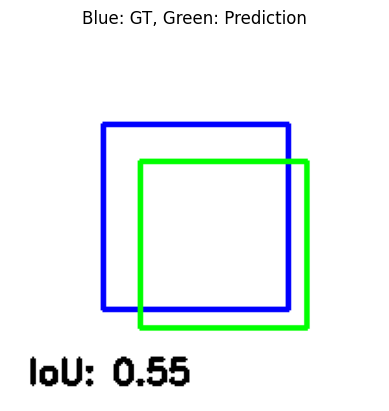

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

# Визуализация bbox и IoU
boxA = [50, 50, 150, 150]
boxB = [70, 70, 160, 160]
image = np.ones((200, 200, 3), dtype=np.uint8) * 255
cv2.rectangle(image, (boxA[0], boxA[1]), (boxA[2], boxA[3]), (255, 0, 0), 2)
cv2.rectangle(image, (boxB[0], boxB[1]), (boxB[2], boxB[3]), (0, 255, 0), 2)
iou_val = iou(boxA, boxB)
cv2.putText(image, f'IoU: {iou_val:.2f}', (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Blue: GT, Green: Prediction")
plt.axis('off')
plt.show()

## 3️⃣ Линейная алгебра: контроль глубины объекта в кадре
Глубина ($Z$) — это расстояние от камеры до объекта. Она может быть вычислена:
- через стереозрение: $Z = \frac{f \cdot B}{d}$
- через относительный размер объекта в кадре:
$$Z \propto \frac{H_{real}}{H_{image}}$$
где $H_{real}$ — известная реальная высота объекта, $H_{image}$ — высота bbox в пикселях.

### 📐 Формула стереозрения:

$$
Z = \frac{f \cdot B}{d}
$$

---

### 🔍 Объяснение переменных:

| Обозначение | Название             | Что означает                                                                 |
|-------------|----------------------|------------------------------------------------------------------------------|
| \( Z \)     | Глубина (Depth)      | Расстояние от камеры до объекта                                              |
| \( f \)     | Фокусное расстояние  | Оптический параметр камеры (в пикселях); показывает, насколько сильно камера «приближает» |
| \( B \)     | Базис (Baseline)     | Расстояние между двумя камерами (обычно в метрах или миллиметрах)           |
| \( d \)     | Disparity (диспаритет) | Разность координат объекта на левом и правом изображениях: \( d = x_{left} - x_{right} \) |

---

### 🧠 Почему это работает?

Когда один и тот же объект наблюдается с двух немного разных точек (две камеры или левый и правый глаз), он будет отображаться **на немного разных позициях** в кадре.

- Чем **ближе объект**, тем **больше диспаритет** \( d \)
- Чем **дальше объект**, тем **меньше диспаритет** \( d \)

Формула показывает:
- Больше \( d \) ⇒ объект ближе ⇒ \( Z \) меньше
- Больше \( f \) или \( B \) ⇒ **точнее можно измерить** \( Z \)

---

### 📸 Фокусное расстояние \( f \) в пикселях?

В компьютерном зрении \( f \) часто выражается в **пикселях**, а не в миллиметрах.  
Обычно его получают из **матрицы внутренней калибровки камеры**:

$$
K =
\begin{bmatrix}
f_x & 0 & c_x \\\\
0 & f_y & c_y \\\\
0 & 0 & 1
\end{bmatrix}
$$

- \( f_x, f_y \) — фокусное расстояние по осям \( x, y \) (в пикселях)
- \( c_x, c_y \) — координаты центра изображения (principal point)

---

### 📘 Мы хотим найти:

Как далеко находится объект от камеры?  
Это расстояние и есть **глубина** — \( Z \)

---

### 🔎 Что означают переменные (ещё раз, просто):

✅ \( Z \) — **что ищем** — глубина (например, 2.4 метра)  
✅ \( f \) — как сильно камера приближает (в пикселях)  
✅ \( B \) — насколько камеры разнесены друг от друга  
✅ \( d \) — как сильно сместился объект на левом и правом изображении

---

### 📌 Пример:

Пусть:
- \( f = 800 \) пикселей (из калибровки)
- \( B = 0.06 \) м (6 см между камерами)
- \( d = 30 \) пикселей

Тогда:

$$
Z = \frac{800 \cdot 0.06}{30} = \frac{48}{30} = 1.6 \text{ метра}
$$

---

### 📷 Как это выглядит визуально:

Ты смотришь двумя глазами. Если поднести палец к носу, он «раздваивается».  
Это и есть **disparity**.  
Две камеры делают то же самое — сравнивают положение объекта на двух изображениях, чтобы понять, **насколько он близко**.


In [4]:
def estimate_depth(h_real_meters, h_bbox_pixels, focal_length_pixels=800):
    return focal_length_pixels * h_real_meters / h_bbox_pixels

depth = estimate_depth(1.7, 170)
print(f"Оценочная глубина: {depth:.2f} метров")

Оценочная глубина: 8.00 метров


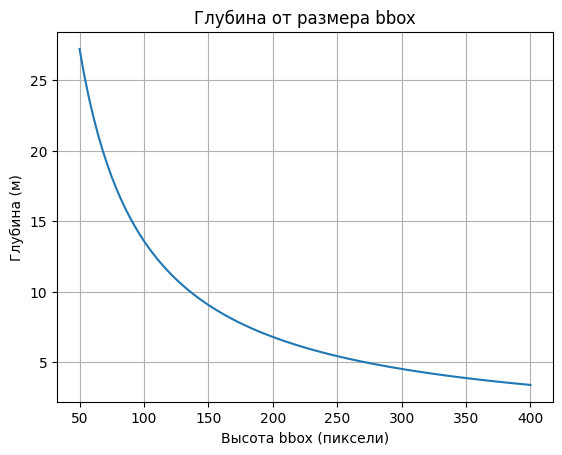

In [5]:
bbox_heights = np.linspace(50, 400, 100)
depths = [estimate_depth(1.7, h) for h in bbox_heights]
plt.plot(bbox_heights, depths)
plt.xlabel("Высота bbox (пиксели)")
plt.ylabel("Глубина (м)")
plt.title("Глубина от размера bbox")
plt.grid(True)
plt.show()

### 📝 Упражнение:
1. Напиши функцию глубины и проверь для:
   - Человека (1.7м), bbox=170px
   - Стола (0.75м), bbox=90px
   - Стула (0.5м), bbox=60px
2. Построй график зависимости глубины от bbox
3. Объясни, как можно повысить точность глубины при помощи калибровки камеры.

In [6]:
depth = estimate_depth(1.7, 170)
print(f"Оценочная глубина: {depth:.2f} метров")

Оценочная глубина: 8.00 метров


In [7]:
depth = estimate_depth(0.75, 90)
print(f"Оценочная глубина: {depth:.2f} метров")

Оценочная глубина: 6.67 метров


In [8]:
depth = estimate_depth(0.5, 60)
print(f"Оценочная глубина: {depth:.2f} метров")

Оценочная глубина: 6.67 метров
